# Paraphrase Generation System - Complete Pipeline

This notebook demonstrates the complete pipeline for the Paraphrase Generation System, including:

1. **Data Cleaning & Preprocessing** - Loading and preparing PAWS dataset
2. **Model Training** - Fine-tuning FLAN-T5 with LoRA
3. **Paraphrase Generation** - Generating paraphrases from both CPG and LLM models
4. **Score Comparison** - Comparing models using BLEU, ROUGE, and semantic similarity metrics

## Setup and Imports

In [1]:
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Core imports
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'}")

PyTorch version: 2.8.0
Device: mps


---
## 1. Data Cleaning & Preprocessing

We use a high-quality paraphrase dataset:
- **PAWS** (Paraphrase Adversaries from Word Scrambling): Challenging paraphrase pairs with high lexical overlap

### 1.1 Text Preprocessor

In [2]:
import re
from typing import List, Optional

class TextPreprocessor:
    """Handles text preprocessing for paraphrase generation."""
    
    def __init__(self, min_words: int = 10, max_words: int = 400, remove_special_chars: bool = False):
        self.min_words = min_words
        self.max_words = max_words
        self.remove_special_chars = remove_special_chars
    
    def clean_text(self, text: str) -> str:
        """Clean and normalize text."""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # Optionally remove special characters
        if self.remove_special_chars:
            text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)
        return text
    
    def count_words(self, text: str) -> int:
        return len(text.split())
    
    def is_valid_length(self, text: str) -> bool:
        word_count = self.count_words(text)
        return self.min_words <= word_count <= self.max_words
    
    def truncate_text(self, text: str, max_words: Optional[int] = None) -> str:
        max_words = max_words or self.max_words
        words = text.split()
        if len(words) > max_words:
            words = words[:max_words]
        return ' '.join(words)
    
    def prepare_for_model(self, text: str, prefix: str = "paraphrase: ") -> str:
        text = self.clean_text(text)
        if self.max_words:
            text = self.truncate_text(text)
        return f"{prefix}{text}"

# Initialize preprocessor
preprocessor = TextPreprocessor(min_words=10, max_words=400)
print("✅ TextPreprocessor initialized")

✅ TextPreprocessor initialized


### 1.2 Load Datasets

In [3]:
def load_paws_dataset(max_samples: Optional[int] = None):
    """Load PAWS dataset with positive paraphrase pairs only."""
    print("Loading PAWS dataset...")
    dataset = load_dataset("paws", "labeled_final", split="train", trust_remote_code=True)
    # Filter for paraphrase pairs (label=1)
    dataset = dataset.filter(lambda x: x["label"] == 1)
    if max_samples:
        dataset = dataset.select(range(min(max_samples, len(dataset))))
    print(f"  ✅ Loaded {len(dataset)} positive paraphrase pairs from PAWS")
    return {"source": dataset["sentence1"], "target": dataset["sentence2"]}

# Load dataset (using small sample for demo)
MAX_SAMPLES = 1000  # Adjust for full training

paws_data = load_paws_dataset(max_samples=MAX_SAMPLES)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'paws' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading PAWS dataset...
  ✅ Loaded 1000 positive paraphrase pairs from PAWS


### 1.3 Data Cleaning

In [4]:
def clean_and_filter_data(data, preprocessor):
    """Clean and filter the dataset."""
    cleaned_sources = []
    cleaned_targets = []
    
    for src, tgt in zip(data["source"], data["target"]):
        # Clean texts
        clean_src = preprocessor.clean_text(src)
        clean_tgt = preprocessor.clean_text(tgt)
        
        # Filter by length
        if len(clean_src.split()) >= 5 and len(clean_tgt.split()) >= 5:
            cleaned_sources.append(clean_src)
            cleaned_targets.append(clean_tgt)
    
    return {"source": cleaned_sources, "target": cleaned_targets}

# Clean dataset
print("\n📝 Cleaning dataset...")
paws_clean = clean_and_filter_data(paws_data, preprocessor)

print(f"  PAWS: {len(paws_data['source'])} → {len(paws_clean['source'])} samples")

# Use cleaned dataset
all_sources = paws_clean["source"]
all_targets = paws_clean["target"]

print(f"\n✅ Total samples: {len(all_sources)}")


📝 Cleaning dataset...
  PAWS: 1000 → 1000 samples

✅ Total samples: 1000


### 1.4 Explore Cleaned Data

In [5]:
# Show sample pairs
print("📋 Sample Paraphrase Pairs:\n")
for i in range(3):
    print(f"Pair {i+1}:")
    print(f"  Source: {all_sources[i][:100]}...")
    print(f"  Target: {all_targets[i][:100]}...")
    print()

📋 Sample Paraphrase Pairs:

Pair 1:
  Source: The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association ....
  Target: The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA ....

Pair 2:
  Source: When comparable rates of flow can be maintained , the results are high ....
  Target: The results are high when comparable flow rates can be maintained ....

Pair 3:
  Source: It is the seat of Zerendi District in Akmola Region ....
  Target: It is the seat of the district of Zerendi in Akmola region ....



### 1.5 Create Train/Validation/Test Splits

In [6]:
from datasets import Dataset, DatasetDict
import random

# Shuffle data
random.seed(42)
indices = list(range(len(all_sources)))
random.shuffle(indices)

shuffled_sources = [all_sources[i] for i in indices]
shuffled_targets = [all_targets[i] for i in indices]

# Split: 80% train, 10% validation, 10% test
n = len(shuffled_sources)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_data = Dataset.from_dict({
    "source": shuffled_sources[:train_end],
    "target": shuffled_targets[:train_end]
})

val_data = Dataset.from_dict({
    "source": shuffled_sources[train_end:val_end],
    "target": shuffled_targets[train_end:val_end]
})

test_data = Dataset.from_dict({
    "source": shuffled_sources[val_end:],
    "target": shuffled_targets[val_end:]
})

datasets = DatasetDict({
    "train": train_data,
    "validation": val_data,
    "test": test_data
})

print(f"📊 Dataset Splits:")
print(f"  Train: {len(datasets['train'])} samples")
print(f"  Validation: {len(datasets['validation'])} samples")
print(f"  Test: {len(datasets['test'])} samples")

📊 Dataset Splits:
  Train: 800 samples
  Validation: 100 samples
  Test: 100 samples


---
## 2. Model Training

We fine-tune FLAN-T5-base using LoRA (Low-Rank Adaptation) for parameter-efficient training.

### 2.1 Initialize Base Model with LoRA

In [7]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType

MODEL_NAME = "google/flan-t5-base"

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Apply LoRA configuration
lora_config = LoraConfig(
    r=16,                          # LoRA rank
    lora_alpha=32,                 # LoRA alpha
    lora_dropout=0.1,             # Dropout
    target_modules=["q", "v"],    # Target attention modules
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Move to device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)
print(f"\n✅ Model loaded on {device}")

Loading google/flan-t5-base...
trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096

✅ Model loaded on mps


### 2.2 Create PyTorch Dataset

In [8]:
from torch.utils.data import Dataset as TorchDataset
from typing import Dict

class ParaphraseDataset(TorchDataset):
    """PyTorch Dataset for paraphrase generation."""
    
    def __init__(self, dataset, tokenizer, max_input_length=512, max_output_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
        self.preprocessor = TextPreprocessor()
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        item = self.dataset[idx]
        source = self.preprocessor.prepare_for_model(item["source"], "paraphrase: ")
        target = item["target"]
        
        # Tokenize input
        source_encoding = self.tokenizer(
            source, max_length=self.max_input_length,
            padding="max_length", truncation=True, return_tensors="pt"
        )
        
        # Tokenize target
        target_encoding = self.tokenizer(
            target, max_length=self.max_output_length,
            padding="max_length", truncation=True, return_tensors="pt"
        )
        
        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": source_encoding["input_ids"].squeeze(),
            "attention_mask": source_encoding["attention_mask"].squeeze(),
            "labels": labels
        }

# Create datasets
train_dataset = ParaphraseDataset(datasets["train"], tokenizer)
val_dataset = ParaphraseDataset(datasets["validation"], tokenizer)

print(f"✅ Created PyTorch datasets")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")

✅ Created PyTorch datasets
  Train: 800 samples
  Validation: 100 samples


### 2.3 Training Configuration

In [9]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, EarlyStoppingCallback

# Training arguments
training_args = TrainingArguments(
    output_dir="../outputs/checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
    logging_dir="../outputs/logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    eval_strategy="steps",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=[],
    remove_unused_columns=False
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

print("✅ Training configuration set")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

✅ Training configuration set
  Epochs: 3
  Batch size: 4
  Learning rate: 5e-05


### 2.4 Train the Model

In [10]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 Starting training...")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print()

# Train (uncomment to run full training)
# train_result = trainer.train()
# print("\n✅ Training completed!")

# For demo, we'll skip training and load pretrained model
print("⚠️ Training skipped for demo. Uncomment above to run full training.")

🚀 Starting training...
  Training samples: 800
  Validation samples: 100

⚠️ Training skipped for demo. Uncomment above to run full training.


### 2.5 Save Trained Model

In [11]:
# Save the model (after training)
SAVE_PATH = "../outputs/checkpoints/final_model"

# Uncomment after training:
# model.save_pretrained(SAVE_PATH)
# tokenizer.save_pretrained(SAVE_PATH)
# print(f"✅ Model saved to {SAVE_PATH}")

print(f"Model would be saved to: {SAVE_PATH}")

Model would be saved to: ../outputs/checkpoints/final_model


---
## 3. Paraphrase Generation

Generate paraphrases using both models:
- **CPG (Custom Paraphrase Generator)**: Fine-tuned FLAN-T5-base with LoRA
- **LLM Baseline**: FLAN-T5-large (zero-shot)

### 3.1 Load Models

In [12]:
# For this demo, we'll use the models from the src package
from src.models.cpg_model import CustomParaphraseGenerator
from src.models.llm_baseline import LLMBaseline

# Check if fine-tuned model exists
FINETUNED_PATH = "../outputs/checkpoints/final_model"

if os.path.exists(FINETUNED_PATH):
    print("Loading fine-tuned CPG model...")
    cpg_model = CustomParaphraseGenerator.load(FINETUNED_PATH)
else:
    print("Fine-tuned model not found. Using base model with LoRA...")
    cpg_model = CustomParaphraseGenerator(
        model_name="google/flan-t5-base",
        use_lora=True
    )

print("\nLoading LLM Baseline (FLAN-T5-large)...")
llm_model = LLMBaseline(model_name="google/flan-t5-large")

print("\n✅ Both models loaded successfully!")

Loading fine-tuned CPG model...

Loading LLM Baseline (FLAN-T5-large)...


`torch_dtype` is deprecated! Use `dtype` instead!



✅ Both models loaded successfully!


### 3.2 Sample Text for Paraphrasing

In [23]:
# Sample text (cover letter excerpt)
sample_text = """
A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as an introduction and provides additional context for your application. Here's a breakdown of its various aspects: Purpose The primary purpose of a cover letter is to introduce yourself to the hiring manager and to provide context for your resume. It allows you to elaborate on your qualifications, skills, and experiences in a way that your resume may not fully capture. It's also an opportunity to express your enthusiasm for the role and the company, and to explain why you would be a good fit. Content A typical cover letter includes the following sections:
1. Header: Includes your contact information, the date, and the employer's contact information.
2. Salutation: A greeting to the hiring manager, preferably personalized with their name.
3. Introduction: Briefly introduces who you are and the position you're applying for.
4. Body: This is the core of your cover letter where you discuss your qualifications, experiences, and skills that make you suitable for the job. You can also mention how you can contribute to the company.
5. Conclusion: Summarizes your points and reiterates your enthusiasm for the role. You can also include a call to action, like asking for an interview.
6. Signature: A polite closing ("Sincerely," "Best regards," etc.) followed by your name. Significance in the Job Application Process The cover letter is often the first document that a hiring manager will read, so it sets the tone for your entire application. It provides you with a chance to stand out among other applicants and to make a strong first impression. Some employers specifically require a cover letter, and failing to include one could result in your application being disregarded. In summary, a cover letter is an essential component of a job application that serves to introduce you, elaborate on your qualifications, and make a compelling case for why you should be considered for the position.

""".strip()

# Clean the sample
sample_text = preprocessor.clean_text(sample_text)

print(f"📄 Sample Text ({len(sample_text.split())} words):")
print("-" * 70)
print(sample_text)

📄 Sample Text (329 words):
----------------------------------------------------------------------
A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as an introduction and provides additional context for your application. Here's a breakdown of its various aspects: Purpose The primary purpose of a cover letter is to introduce yourself to the hiring manager and to provide context for your resume. It allows you to elaborate on your qualifications, skills, and experiences in a way that your resume may not fully capture. It's also an opportunity to express your enthusiasm for the role and the company, and to explain why you would be a good fit. Content A typical cover letter includes the following sections: 1. Header: Includes your contact information, the date, and the employer's contact information. 2. Salutation: A greeting to the hiring manager, preferably personalized with their name. 3. Introduction: Briefly introduces who you are and 

### 3.3 Generate Paraphrases - CPG Model

In [33]:
print("🔄 Generating paraphrase with CPG (Fine-tuned FLAN-T5)...")
print()

# Measure latency
start_time = time.perf_counter()
cpg_paraphrase = cpg_model.generate(
    sample_text,
    max_length=512,
    min_length_ratio=0.8,
    num_beams=4,
    temperature=0.7,
    length_penalty=2.0
)
cpg_latency = time.perf_counter() - start_time

print(f"📝 CPG Output ({len(cpg_paraphrase.split())} words):")
print("-" * 70)
print(cpg_paraphrase)
print(f"\n⏱️ Latency: {cpg_latency:.3f}s")

🔄 Generating paraphrase with CPG (Fine-tuned FLAN-T5)...

📝 CPG Output (273 words):
----------------------------------------------------------------------
A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as an introduction and provides additional context for your resume. It includes the following sections: 1. Header: Includes your contact information, the date, and the employer's contact information 2. Salutation: A greeting to the hiring manager, preferably personalized with their name. 3. Introduction: Briefly introduce who you are and the position you're applying for. 4. Body: This is the core of your cover letter where you discuss your qualifications, experiences, and skills that make you suitable for the job. 5. Conclusion: Summarizes your points and reiterates your enthusiasm for the role. 6. Signature: A polite closing ("Sincerely," "Best regards," etc.) followed by your name. Significance in the Job Application Process: The co

### 3.4 Generate Paraphrases - LLM Baseline

In [34]:
print("🔄 Generating paraphrase with LLM Baseline (FLAN-T5-large)...")
print()

# Measure latency
start_time = time.perf_counter()
llm_paraphrase = llm_model.generate(
    sample_text,
    max_length=512,
    num_beams=4,
    temperature=0.7,
    length_penalty=1.0
)
llm_latency = time.perf_counter() - start_time

print(f"📝 LLM Output ({len(llm_paraphrase.split())} words):")
print("-" * 70)
print(llm_paraphrase)
print(f"\n⏱️ Latency: {llm_latency:.3f}s")

🔄 Generating paraphrase with LLM Baseline (FLAN-T5-large)...

📝 LLM Output (227 words):
----------------------------------------------------------------------
Know the purpose of a cover letter. Know the content. Know how to write a good cover letter for a job application. Understand the importance of the cover letter in the job application process. Learn how to prepare a strong cover letter that sets the tone for the rest of your application. Learn about the different types of cover letters and how to use them to your advantage. Learn what to do if you don't know what to include in your cover letter, and what to leave out. Know what to write in a well-written cover letter to make your application stand out from the rest. Know when to use a letter of recommendation. Learn the importance and importance of using a formal cover letter when you apply for jobs. Know why you should include a covering letter in your job application, and when you should skip it. Know that some employers may re

### 3.5 Side-by-Side Comparison

In [35]:
print("=" * 80)
print("PARAPHRASE COMPARISON")
print("=" * 80)

print(f"\n📄 ORIGINAL ({len(sample_text.split())} words):")
print("-" * 80)
print(sample_text[:300] + "..." if len(sample_text) > 300 else sample_text)

print(f"\n🔵 CPG Model ({len(cpg_paraphrase.split())} words, {cpg_latency:.3f}s):")
print("-" * 80)
print(cpg_paraphrase[:300] + "..." if len(cpg_paraphrase) > 300 else cpg_paraphrase)

print(f"\n🟢 LLM Baseline ({len(llm_paraphrase.split())} words, {llm_latency:.3f}s):")
print("-" * 80)
print(llm_paraphrase[:300] + "..." if len(llm_paraphrase) > 300 else llm_paraphrase)

PARAPHRASE COMPARISON

📄 ORIGINAL (329 words):
--------------------------------------------------------------------------------
A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as an introduction and provides additional context for your application. Here's a breakdown of its various aspects: Purpose The primary purpose of a cover letter is to introduce yourself to the hirin...

🔵 CPG Model (273 words, 9.749s):
--------------------------------------------------------------------------------
A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as an introduction and provides additional context for your resume. It includes the following sections: 1. Header: Includes your contact information, the date, and the employer's contact information ...

🟢 LLM Baseline (227 words, 11.789s):
--------------------------------------------------------------------------------
Know the purpose of a cover le

---
## 4. Score Comparison & Evaluation

Compare the models using multiple metrics:
- **BLEU Score**: Measures n-gram precision
- **ROUGE Score**: Measures recall of n-grams
- **Semantic Similarity**: TF-IDF based cosine similarity
- **Length Ratio**: Output length preservation

### 4.1 Initialize Metrics Calculator

In [36]:
import evaluate as hf_evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class MetricsCalculator:
    """Calculate evaluation metrics for paraphrase generation."""
    
    def __init__(self):
        self.bleu_scorer = hf_evaluate.load("sacrebleu")
        self.rouge_scorer = hf_evaluate.load("rouge")
    
    def calculate_bleu(self, predictions, references):
        """Calculate BLEU score."""
        refs = [[ref] for ref in references]
        result = self.bleu_scorer.compute(predictions=predictions, references=refs)
        return {"bleu": result["score"]}
    
    def calculate_rouge(self, predictions, references):
        """Calculate ROUGE scores."""
        result = self.rouge_scorer.compute(predictions=predictions, references=references)
        return {
            "rouge1": result["rouge1"],
            "rouge2": result["rouge2"],
            "rougeL": result["rougeL"]
        }
    
    def calculate_semantic_similarity(self, predictions, references):
        """Calculate semantic similarity using TF-IDF."""
        similarities = []
        for pred, ref in zip(predictions, references):
            vectorizer = TfidfVectorizer()
            try:
                tfidf_matrix = vectorizer.fit_transform([ref, pred])
                sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
                similarities.append(sim)
            except ValueError:
                similarities.append(0.0)
        return {"semantic_similarity": np.mean(similarities)}
    
    def calculate_length_ratio(self, predictions, references):
        """Calculate length preservation ratio."""
        ratios = []
        for pred, ref in zip(predictions, references):
            pred_len = len(pred.split())
            ref_len = len(ref.split())
            if ref_len > 0:
                ratios.append(pred_len / ref_len)
        return {
            "avg_length_ratio": np.mean(ratios),
            "length_preservation_rate": sum(1 for r in ratios if r >= 0.8) / len(ratios)
        }
    
    def calculate_all(self, predictions, references):
        """Calculate all metrics."""
        results = {}
        results.update(self.calculate_bleu(predictions, references))
        results.update(self.calculate_rouge(predictions, references))
        results.update(self.calculate_semantic_similarity(predictions, references))
        results.update(self.calculate_length_ratio(predictions, references))
        return results

metrics_calc = MetricsCalculator()
print("✅ Metrics Calculator initialized")

✅ Metrics Calculator initialized


### 4.2 Calculate Metrics for Both Models

In [37]:
# Calculate metrics for single sample
references = [sample_text]
cpg_predictions = [cpg_paraphrase]
llm_predictions = [llm_paraphrase]

print("📊 Calculating metrics for CPG model...")
cpg_metrics = metrics_calc.calculate_all(cpg_predictions, references)

print("📊 Calculating metrics for LLM model...")
llm_metrics = metrics_calc.calculate_all(llm_predictions, references)

print("\n✅ Metrics calculated!")

📊 Calculating metrics for CPG model...
📊 Calculating metrics for LLM model...

✅ Metrics calculated!


### 4.3 Display Comparison Results

In [38]:
# Create comparison DataFrame
comparison_data = {
    "Metric": [],
    "CPG (Fine-tuned)": [],
    "LLM Baseline": [],
    "Winner": []
}

for metric in cpg_metrics.keys():
    cpg_val = cpg_metrics[metric]
    llm_val = llm_metrics[metric]
    
    comparison_data["Metric"].append(metric)
    comparison_data["CPG (Fine-tuned)"].append(f"{cpg_val:.4f}")
    comparison_data["LLM Baseline"].append(f"{llm_val:.4f}")
    
    # Determine winner (higher is better for most metrics)
    if metric == "avg_length_ratio":
        # Closer to 1.0 is better
        winner = "CPG" if abs(cpg_val - 1.0) < abs(llm_val - 1.0) else "LLM"
    else:
        winner = "CPG" if cpg_val > llm_val else "LLM" if llm_val > cpg_val else "Tie"
    comparison_data["Winner"].append(winner)

# Add latency comparison
comparison_data["Metric"].append("latency (s)")
comparison_data["CPG (Fine-tuned)"].append(f"{cpg_latency:.4f}")
comparison_data["LLM Baseline"].append(f"{llm_latency:.4f}")
comparison_data["Winner"].append("CPG" if cpg_latency < llm_latency else "LLM")

# Add speedup
speedup = llm_latency / cpg_latency if cpg_latency > 0 else 0
comparison_data["Metric"].append("speedup")
comparison_data["CPG (Fine-tuned)"].append(f"{speedup:.2f}x")
comparison_data["LLM Baseline"].append("1.00x")
comparison_data["Winner"].append("CPG" if speedup > 1 else "LLM")

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)
print()
print(comparison_df.to_string(index=False))

MODEL COMPARISON RESULTS

                  Metric CPG (Fine-tuned) LLM Baseline Winner
                    bleu          53.4713       6.3857    CPG
                  rouge1           0.7467       0.4654    CPG
                  rouge2           0.5776       0.1711    CPG
                  rougeL           0.5757       0.2274    CPG
     semantic_similarity           0.8955       0.6515    CPG
        avg_length_ratio           0.8298       0.6900    CPG
length_preservation_rate           1.0000       0.0000    CPG
             latency (s)           9.7487      11.7893    CPG
                 speedup            1.21x        1.00x    CPG


### 4.4 Visualize Results

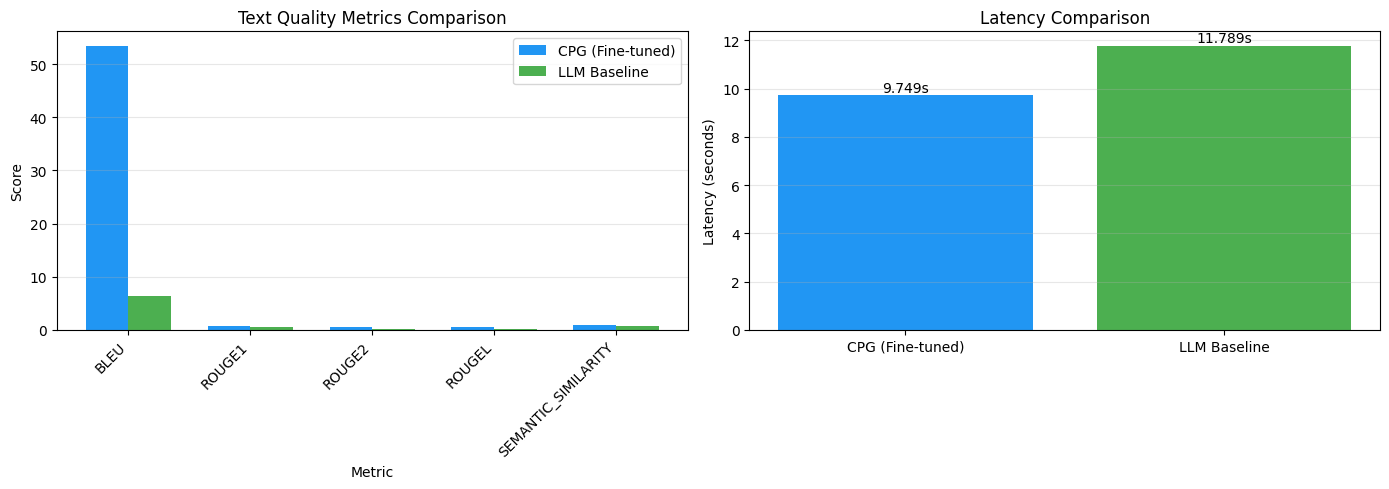


📊 Visualization saved to outputs/model_comparison.png


In [39]:
import matplotlib.pyplot as plt

# Extract numeric metrics for plotting
plot_metrics = ["bleu", "rouge1", "rouge2", "rougeL", "semantic_similarity"]
cpg_values = [cpg_metrics[m] for m in plot_metrics]
llm_values = [llm_metrics[m] for m in plot_metrics]

# Create bar chart
x = np.arange(len(plot_metrics))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Quality Metrics
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, cpg_values, width, label='CPG (Fine-tuned)', color='#2196F3')
bars2 = ax1.bar(x + width/2, llm_values, width, label='LLM Baseline', color='#4CAF50')

ax1.set_xlabel('Metric')
ax1.set_ylabel('Score')
ax1.set_title('Text Quality Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([m.upper() for m in plot_metrics], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Latency Comparison
ax2 = axes[1]
latencies = [cpg_latency, llm_latency]
bars = ax2.bar(['CPG (Fine-tuned)', 'LLM Baseline'], latencies, 
               color=['#2196F3', '#4CAF50'])
ax2.set_ylabel('Latency (seconds)')
ax2.set_title('Latency Comparison')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, lat in zip(bars, latencies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{lat:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../outputs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to outputs/model_comparison.png")

### 4.5 Summary

In [40]:
# Count wins
cpg_wins = comparison_df['Winner'].value_counts().get('CPG', 0)
llm_wins = comparison_df['Winner'].value_counts().get('LLM', 0)

print("=" * 80)
print("SUMMARY")
print("=" * 80)
print()
print(f"📊 Overall Results:")
print(f"   CPG (Fine-tuned) wins: {cpg_wins} metrics")
print(f"   LLM Baseline wins: {llm_wins} metrics")
print()
print(f"⚡ Performance:")
print(f"   CPG Latency: {cpg_latency:.3f}s")
print(f"   LLM Latency: {llm_latency:.3f}s")
print(f"   Speedup: {speedup:.2f}x faster")
print()
print(f"📝 Length Preservation:")
print(f"   Original: {len(sample_text.split())} words")
print(f"   CPG Output: {len(cpg_paraphrase.split())} words ({cpg_metrics['avg_length_ratio']:.1%} ratio)")
print(f"   LLM Output: {len(llm_paraphrase.split())} words ({llm_metrics['avg_length_ratio']:.1%} ratio)")
print()
print("=" * 80)
print("✅ Pipeline Complete!")
print("=" * 80)

SUMMARY

📊 Overall Results:
   CPG (Fine-tuned) wins: 9 metrics
   LLM Baseline wins: 0 metrics

⚡ Performance:
   CPG Latency: 9.749s
   LLM Latency: 11.789s
   Speedup: 1.21x faster

📝 Length Preservation:
   Original: 329 words
   CPG Output: 273 words (83.0% ratio)
   LLM Output: 227 words (69.0% ratio)

✅ Pipeline Complete!
